In [31]:
"""#%pip install datasets"""
import ast
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#getdata
dataset=load_dataset('lukebarousse/data_jobs')
df=dataset['train'].to_pandas()
#cleandata
df['job_posted_date']=pd.to_datetime(df['job_posted_date'])
df['job_skills']=df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [191]:
#get only data engineering jobs in US
df_DE_US=df[(df['job_title_short']=="Data Engineer") & (df['job_country']=='United States')].copy()
#drop nan values from 'salary_year_avg' col.
df_DE_US = df_DE_US.dropna(subset=['salary_year_avg'])

In [33]:
# Now get accurate counts
print("Total Data Engineer jobs in US:", len(df_DE_US))
print("With salary info:", df_DE_US['salary_year_avg'].notna().sum())


Total Data Engineer jobs in US: 2915
With salary info: 2915


In [34]:
df_DE_US=df_DE_US.explode('job_skills')

df_DE_US[['salary_year_avg','job_skills']]

df_DE_US_grouped=df_DE_US.groupby('job_skills')['salary_year_avg'].agg(['count','median'])


df_DE_wantedskills=df_DE_US_grouped.sort_values(by='median', ascending=False).sort_values(by='count',ascending=False).head(6)
df_DE_wantedskills=df_DE_wantedskills.sort_values(by='median')

df_DE_biggestsalary=df_DE_US_grouped.sort_values(by='median', ascending=False).head(6)

df_DE_wantedskills 


,count,median
job_skills,,
sql,2110,125000.00000
azure,961,125000.00000
python,2007,127794.50000
snowflake,765,130700.00000
aws,1313,131000.00000
spark,968,137410.15625


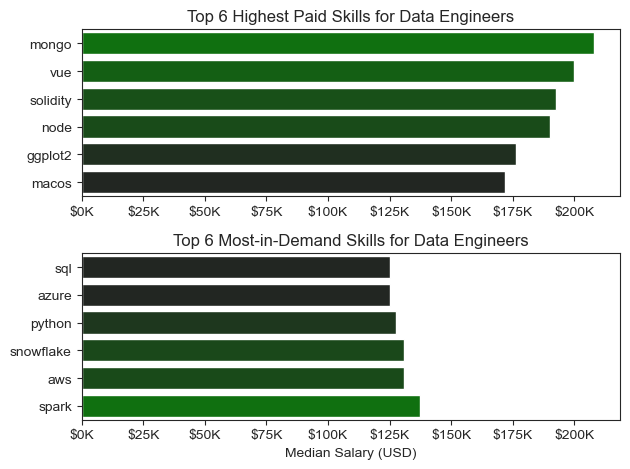

In [35]:
#graph for top 6 paid skills and top 6 most in demand skills for data engineers
fig, ax = plt.subplots(2, 1)

sns.barplot(data=df_DE_biggestsalary, x='median', y=df_DE_biggestsalary.index, ax=ax[0], legend=False, hue='median', palette='dark:g')
ax[0].invert_yaxis
ax[0].set_title('Top 6 Highest Paid Skills for Data Engineers')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_:f'${int(x/1000)}K'))

sns.barplot(data=df_DE_wantedskills, x='median', y=df_DE_wantedskills.index, ax=ax[1], legend=False, hue='median', palette='dark:g')
ax[1].invert_yaxis
ax[1].set_title('Top 6 Most-in-Demand Skills for Data Engineers')
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary (USD)')
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_:f'${int(x/1000)}K'))
ax[1].set_xlim(ax[0].get_xlim())


fig.tight_layout()

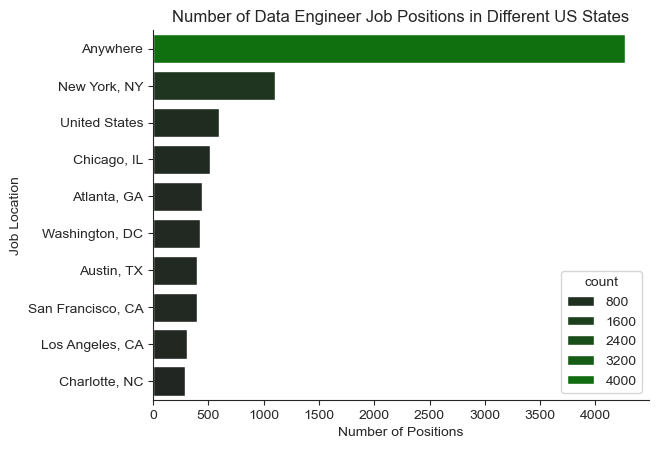

In [36]:
DE_job_locations=df_DE_US['job_location'].value_counts().head(10).to_frame()
sns.set_style('ticks')
ax=sns.barplot(data=DE_job_locations, x='count', y='job_location', hue='count', palette='dark:g')
ax.set(xlabel='Number of Positions', ylabel='Job Location')
plt.title("Number of Data Engineer Job Positions in Different US States")
sns.despine()
plt.show()

In [37]:
#Now we are setting up back a new dataframe with data only from the US and not filtering by data engineer
df_US=df[df['job_country']=='United States']
#exploding skills to get skill list 
df_skills=df_US.explode('job_skills')
df_skills[['job_title_short','job_skills']]

,job_title_short,job_skills
0,Senior Data Engineer,None
3,Data Engineer,python
3,Data Engineer,c++
3,Data Engineer,java
3,Data Engineer,matlab
...,...,...
785692,Data Scientist,r
785703,Data Analyst,None
785705,Data Analyst,sql
785705,Data Analyst,python


In [38]:
#get the skill count next to the short job title
df_skills_count=df_skills.groupby(['job_skills','job_title_short']).size()
#reset the index so its not a series 
df_skills_count=df_skills_count.reset_index(name='skill_count')
#sort normally to get ready for visualization
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count['skill_count'] = df_skills_count['skill_count'].astype(int)

df_skills_count

,job_skills,job_title_short,skill_count
1209,python,Data Scientist,42379
1521,sql,Data Analyst,34452
1523,sql,Data Scientist,30034
455,excel,Data Analyst,27519
1243,r,Data Scientist,26022
...,...,...,...
1785,vue.js,Business Analyst,1
60,arch,Business Analyst,1
71,asana,Machine Learning Engineer,1
968,no-sql,Machine Learning Engineer,1


In [39]:
#count the percentage for a skill in a job posting (optional and hard)

df_job_title_count=df_US['job_title_short'].value_counts().reset_index(name='jobs_total') 

#merge with  df_skills_count

dfpercent=pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short')

#count percentage of skills needed which is skillcount/jobstotal*100

dfpercent['skill_percent']=dfpercent['skill_count']/dfpercent['jobs_total']*100
dfpercent

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Scientist,42379,58830,72.036376
1,sql,Data Analyst,34452,67816,50.802171
2,sql,Data Scientist,30034,58830,51.052184
3,excel,Data Analyst,27519,67816,40.578919
4,r,Data Scientist,26022,58830,44.232534
...,...,...,...,...,...
1865,vue.js,Business Analyst,1,7382,0.013546
1866,arch,Business Analyst,1,7382,0.013546
1867,asana,Machine Learning Engineer,1,921,0.108578
1868,no-sql,Machine Learning Engineer,1,921,0.108578


In [ ]:
#get unique job titles into a list
job_titles=df_skills_count['job_title_short'].unique().tolist()
#sort job titles and slice by top 3
job_titles=sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

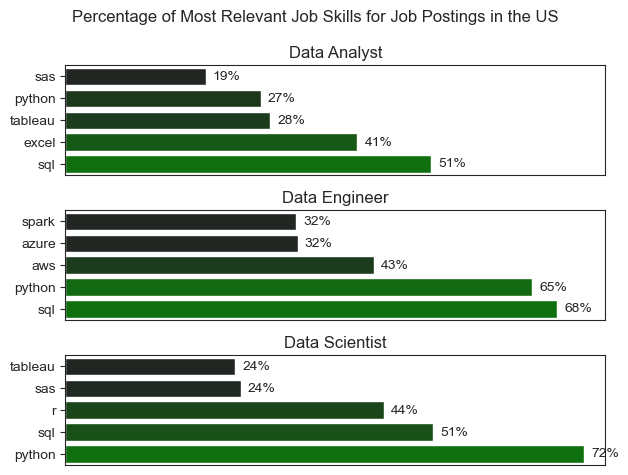

In [41]:
#plotting the horizontal barplot
fig, ax = plt.subplots(len(job_titles),1)
for i, job_title in enumerate(job_titles):
    df_plot = dfpercent[dfpercent['job_title_short']==job_title].head(5) 
    sns.barplot(data=df_plot, x='skill_percent',y='job_skills', ax=ax[i], hue='skill_count', palette='dark:g')
    ax[i].invert_yaxis()
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xlim(0, 75)
    ax[i].legend().set_visible(False)
    
    #this code for putting clean percentages on the bar plot, could never write myself, followed tutorial
    for n, v in enumerate(df_plot['skill_percent']):
            ax[i].text(v+1, n, f'{v:.0f}%', va='center')
                
    ax[i].set_xticks([])
fig.suptitle('Percentage of Most Relevant Job Skills for Job Postings in the US')
fig.tight_layout()
plt.show()